### Imports

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
from pathlib import Path
scripts_path = Path("../Data-Preprocessing/").resolve()
sys.path.append(str(scripts_path))

In [3]:
import pickle
from sklearn.cluster import KMeans
from scripts.data_visualiser import *
from scripts.data_loader import *
from scripts.data_preprocessor import *
from scripts.temporal_data_preprocessor import *
from scripts.temporal_data_loader import *
from scripts.temporal_visualiser import *
from scripts.temporal_chanel_refinement import *
from model_scripts.feature_extraction import *
from model_scripts.get_statistics import *
from model_scripts.dataset_creation import *
from model_scripts.train_model_ae import *
from model_scripts.pre_trained_extraction import *
from Pipeline.pre_processing_pipeline import *
import numpy as np
import preprocessing_config as config
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score
from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA
import skimage.measure
import torch
import torch.nn as nn
import torch.optim as optim

### Loading the data

Train

In [4]:
temporal_images = load_field_images_temporal(config.base_directory_temporal_train)
border_removed_images_train = blacken_field_borders_temporal(temporal_images)
non_temporal_images = get_non_temporal_images(border_removed_images_train)
field_numbers, refined_images_train = refine_chanel_non_temporal(non_temporal_images)

len(refined_images_train), refined_images_train[0].shape

(2425, (64, 64, 6))

Test

In [5]:
temporal_images_test = load_field_images_temporal(config.base_directory_temporal_test)
border_removed_images_test = blacken_field_borders_temporal(temporal_images_test)
non_temporal_images_test = get_non_temporal_images(border_removed_images_test)
field_numbers_test, refined_images_test = refine_chanel_non_temporal(non_temporal_images_test)

(len(refined_images_test), refined_images_test[0].shape)

(48, (64, 64, 6))

In [6]:
image_tensor_train = np.stack(refined_images_train)  # Shape: (N x 64 x 64 x 6)
image_tensor_test = np.stack(refined_images_test)   # Shape: (N x 64 x 64 x 6)

Data Loaders

In [7]:
batch_size = 32
dataloader_train = create_data_loader(image_tensor_train, field_numbers, batch_size=batch_size, shuffle=True)

# Iterate over DataLoader
for batch_inputs, batch_field_numbers in dataloader_train:
    print("Batch Inputs Shape:", batch_inputs.shape)  # Should be (batch_size, C, H, W)
    print("Batch Field Numbers:", batch_field_numbers)
    break  # Show one batch

Batch Inputs Shape: torch.Size([32, 6, 64, 64])
Batch Field Numbers: ('1169493.0', '1224345.0', '1225182.0', '1168657.0', '1223244.0', '1218028.0', '1169812.0', '1167215.0', '1220465.0', '1168384.0_1168385.0_1168386.0', '1191558.0', '1226041.0', '1228636.0', '1222477.0', '1187300.0', '1168624.0', '1227660.0', '1978', '1195388.0', '1227868.0', '1177943.0', '1227107.0', '693', '1218208.0', '1228541.0', '1227504.0', '1222499.0', '811', '1183989.0', '1177638.0_1177639.0', '1220100.0', '1176663.0_1223557.0')


In [8]:
batch_size = 32
dataloader_test = create_data_loader(image_tensor_test, field_numbers_test, batch_size=batch_size, shuffle=False)

# Iterate over DataLoader
for batch_inputs, batch_field_numbers in dataloader_test:
    print("Batch Inputs Shape:", batch_inputs.shape)  # Should be (batch_size, C, H, W)
    print("Batch Field Numbers:", batch_field_numbers)
    break  # Show one batch

Batch Inputs Shape: torch.Size([32, 6, 64, 64])
Batch Field Numbers: ('1168039.0', '1228889.0', '1168663.0_1176271.0', '1168692.0_1220431.0', '1171179.0_1222688.0', '5', '1172001.0_1225692.0', '1174805.0', '1176318.0', '1176365.0', '1177274.0', '1177490.0', '1177490.0_1183928.0', '1178038.0', '1178198.0_1225298.0', '1179855.0_1187336.0', '1182776.0', '1182822.0_1216964.0', '1183171.0', '1194806.0_1194808.0', '1196327.0', '1196347.0', '1196489.0_1196747.0', '1216230.0_1219006.0', '1216239.0', '1216250.0', '1216801.0_1216804.0', '1217032.0', '1217498.0', '1219929.0_1219932.0', '1220322.0', '1222641.0')


### Modeling (6 Bands)

- Resnet50: 54.09%
- VGG16: 62.29%

Train and Test Features

In [1]:
in_channels = 6
model_type = 'resnet50'
feature_extractor = get_pretrained_resnet50(in_channels)

NameError: name 'get_pretrained_resnet50' is not defined

In [10]:
train_features, train_fields = extract_features(feature_extractor, dataloader_train, model_type)
test_features, test_fields = extract_features(feature_extractor, dataloader_test, model_type)

In [11]:
train_features.shape

(2425, 2048)

Clustering

In [17]:
kmeans = perform_clustering(train_features, n_clusters=2, random_state=34)
train_predictions = kmeans.labels_ 

/Users/bhumikasadbhave007/tensorflow-test/env/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [18]:
test_predictions = kmeans.predict(test_features)

In [19]:
##### Saving train predictions -> for future #####
# train_clustering_output = {"fields": train_fields, "labels": train_predictions.tolist()}
# np.save(f"{output_dir}/train_clustering_labels.npy", train_clustering_output)

### Evaluation

In [20]:
test_gt_aligned, test_pred_aligned = get_gt_and_pred_aligned(test_fields, test_predictions, config.labels_path)

test_metrics = evaluate_clustering_metrics(test_gt_aligned, test_pred_aligned)
test_metrics

{'Accuracy': 0.4918032786885246,
 'Adjusted Rand Index (ARI)': -0.016739551222309842,
 'Normalized Mutual Information (NMI)': 0.0005079707524754784,
 'Fowlkes-Mallows Index (FMI)': 0.5086488070118469}

## Vegetation Indices

- NDVI
- MSI
- EVI
- NDVI+MSI+EVI

### Loading

In [4]:
temporal_images = load_field_images_temporal(config.base_directory_temporal_train)
border_removed_images_train = blacken_field_borders_temporal(temporal_images)

# field_numbers, indices_images = indexbands_temporal_cubes(border_removed_images_train, 'msi')
field_numbers, indices_images = allbands_temporal_cubes(border_removed_images_train)
non_temporal_images = get_non_temporal_images(indices_images)
refined_images_train = non_temporal_images
len(refined_images_train), refined_images_train[0].shape

(2425, (64, 64, 10))

In [5]:
temporal_images_test = load_field_images_temporal(config.base_directory_temporal_test)
border_removed_images_test = blacken_field_borders_temporal(temporal_images_test)

# field_numbers_test, indices_images_test = indexbands_temporal_cubes(border_removed_images_test, 'msi')
field_numbers_test, indices_images_test = allbands_temporal_cubes(border_removed_images_test)
non_temporal_images_test = get_non_temporal_images(indices_images_test)
refined_images_test = non_temporal_images_test
(len(refined_images_test), refined_images_test[0].shape)

(48, (64, 64, 10))

In [6]:
image_tensor_train = np.stack(refined_images_train)  # Shape: (N x 64 x 64 x 3)
image_tensor_test = np.stack(refined_images_test)   # Shape: (N x 64 x 64 x 3)

Data Loaders

In [7]:
batch_size = 32
dataloader_train = create_data_loader(image_tensor_train, field_numbers, batch_size=batch_size, shuffle=True)

# Iterate over DataLoader
for batch_inputs, batch_field_numbers in dataloader_train:
    print("Batch Inputs Shape:", batch_inputs.shape)  # Should be (batch_size, C, H, W)
    print("Batch Field Numbers:", batch_field_numbers)
    break  # Show one batch

Batch Inputs Shape: torch.Size([32, 10, 64, 64])
Batch Field Numbers: ('1194730.0', '1175689.0', '1184084.0_1184085.0_1184087.0', '1194718.0_1223476.0', '1172264.0', '1227972.0_1227975.0_1228168.0', '1195774.0_1216482.0', '1234423.0', '1220372.0', '1177537.0_1177554.0', '1183007.0', '1225860.0', '1225424.0', '1218432.0', '1218731.0', '1167168.0', '1224482.0', '1220383.0', '1219877.0', '1223911.0', '1178200.0_1216941.0', '1225706.0', '1219446.0_1219447.0', '1223154.0', '1225393.0', '1223430.0', '1223501.0', '1176368.0', '1222786.0_1222788.0', '1217825.0', '1224231.0', '1224043.0_1224048.0_1224191.0')


In [8]:
batch_size = 32
dataloader_test = create_data_loader(image_tensor_test, field_numbers_test, batch_size=batch_size, shuffle=False)

# Iterate over DataLoader
for batch_inputs, batch_field_numbers in dataloader_test:
    print("Batch Inputs Shape:", batch_inputs.shape)  # Should be (batch_size, C, H, W)
    print("Batch Field Numbers:", batch_field_numbers)
    break  # Show one batch

Batch Inputs Shape: torch.Size([32, 10, 64, 64])
Batch Field Numbers: ('1168039.0', '1228889.0', '1168663.0_1176271.0', '1168692.0_1220431.0', '1171179.0_1222688.0', '5', '1172001.0_1225692.0', '1174805.0', '1176318.0', '1176365.0', '1177274.0', '1177490.0', '1177490.0_1183928.0', '1178038.0', '1178198.0_1225298.0', '1179855.0_1187336.0', '1182776.0', '1182822.0_1216964.0', '1183171.0', '1194806.0_1194808.0', '1196327.0', '1196347.0', '1196489.0_1196747.0', '1216230.0_1219006.0', '1216239.0', '1216250.0', '1216801.0_1216804.0', '1217032.0', '1217498.0', '1219929.0_1219932.0', '1220322.0', '1222641.0')


### Modeling

In [9]:
in_channels = 10
model_type = 'resnet50'
feature_extractor = get_pretrained_resnet50(in_channels)

In [10]:
train_features, train_fields = extract_features(feature_extractor, dataloader_train, model_type)
test_features, test_fields = extract_features(feature_extractor, dataloader_test, model_type)

In [11]:
train_features.shape

(2425, 2048)

Clustering

In [12]:
kmeans = perform_clustering(train_features, n_clusters=2, random_state=24)
train_predictions = kmeans.labels_ 

/Users/bhumikasadbhave007/tensorflow-test/env/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [13]:
test_predictions = kmeans.predict(test_features)

### Evaluation

In [14]:
test_gt_aligned, test_pred_aligned = get_gt_and_pred_aligned(test_fields, test_predictions, config.labels_path)

test_metrics = evaluate_clustering_metrics(test_gt_aligned, test_pred_aligned)
test_metrics

{'Accuracy': 0.5573770491803278,
 'Adjusted Rand Index (ARI)': -0.0034404902698634554,
 'Normalized Mutual Information (NMI)': 0.017123121497155464,
 'Fowlkes-Mallows Index (FMI)': 0.5070171311434776}

In [4]:
temporal_images_test = load_field_images_temporal(config.base_directory_temporal_test)

In [28]:
np.unique(temporal_images_test[10][0][:,:,-2])

array([      0., 1177274.])

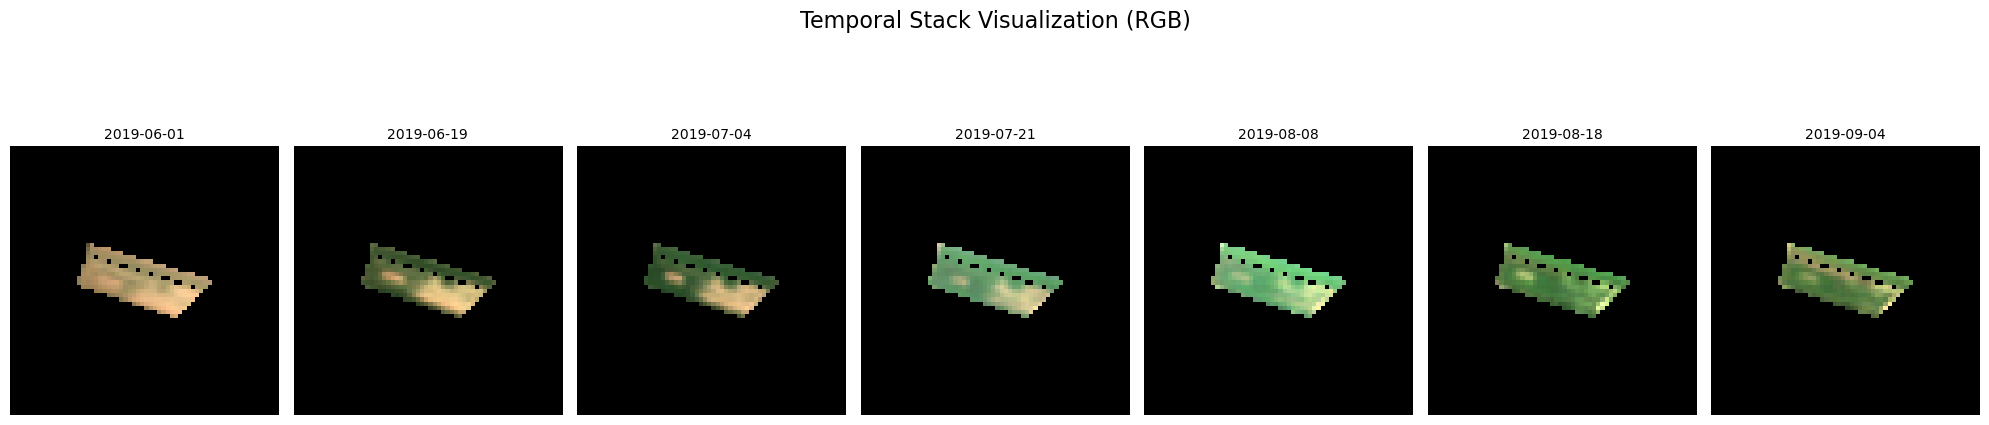

In [37]:
visualize_temporal_stack_rgb(temporal_images_test[4])

## Pre-trained Models: torchgeo

In [ ]:
from torchgeo.models import ResNet18_Weights
from torchgeo.models import resnet18

# Load the ResNet18 model pretrained on Sentinel-2 all bands
model = resnet18(weights=ResNet18_Weights.SENTINEL2_ALL_MOCO)




In [ ]:
import torch.nn as nn

# Remove the final classification layer
model = nn.Sequential(*list(model.children())[:-1])

# Set to evaluation mode for inference
model.eval()

In [ ]:
# Example input tensor (Sentinel-2 with 13 channels, batch size 32)
# input_tensor = torch.randn(32, 13, 224, 224)

# Extract features
with torch.no_grad():
    features = model(input_tensor)  # Output shape: [batch_size, feature_dim, 1, 1]

# Flatten features to [batch_size, feature_dim]
features = features.view(features.size(0), -1)

features_np = features.cpu().numpy()

In [ ]:
# K-means

num_clusters = 2  
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
kmeans.fit(features_np)